In [11]:
import numpy as np
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import seaborn as sns
from data_preprocessing import load_combined_data
import torch.nn.functional as F

In [12]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # disables optimizations for reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [13]:
# Load the combined_labels.npy file
mytool = "electric_screwdriver" # pneumatic_screwdriver,electric_screwdriver
output_dir = "./processed_data/"

# Load the saved NumPy arrays
combined_data_train = np.load(os.path.join(output_dir, f"combined_data_train_{mytool}.npy"))
combined_labels_train = np.load(os.path.join(output_dir, f"combined_label_train_{mytool}.npy"))

# Load the saved NumPy arrays
combined_data_test = np.load(os.path.join(output_dir, f"combined_data_test_{mytool}.npy"))
combined_labels_test = np.load(os.path.join(output_dir, f"combined_label_test_{mytool}.npy"))

In [ ]:
if mytool == "electric_screwdriver":
    label_info = {
        2: 'tightening',
        3: 'untightening',
        4: 'motor_activity_cw',
        5: 'motor_activity_ccw',
        6: 'manual_motor_rotation',
        7: 'shaking',
        14: 'tightening_double'
    }
elif mytool == "pneumatic_screwdriver":
    label_info = {
        2: 'tightening',
        3: 'untightening',
        4: 'motor_activity_cw',
        5: 'motor_activity_ccw',
        7: 'shaking',
        14: 'tightening_double',
        38: 'impact'
    }

valid_labels = list(label_info.keys())

# Apply label encoder and conver to tensor for training

X_train = combined_data_train
y_train = combined_labels_train

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train_encoded)

# Apply label encoder and convert to tensor for testing
X_test = combined_data_test
y_test = combined_labels_test

y_test_encoded = label_encoder.fit_transform(y_test) 

X_tensor_test = torch.FloatTensor(X_test)
y_tensor_test = torch.LongTensor(y_test_encoded)

# ---------------- Model and Loss ---------------- #
class EnhancedToolLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.3):
        super(EnhancedToolLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        out = self.dropout(last_out)
        return self.fc(out)

class SimpleFocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None):
        super(SimpleFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = torch.tensor(alpha, dtype=torch.float32) if alpha is not None else None

    def forward(self, inputs, targets):
        device = inputs.device
        log_probs = F.log_softmax(inputs, dim=1)
        probs = log_probs.exp()
        log_probs_true = log_probs.gather(1, targets.view(-1, 1)).squeeze(1)
        probs_true = probs.gather(1, targets.view(-1, 1)).squeeze(1).clamp(min=1e-9)
        if self.alpha is not None:
            alpha_t = self.alpha.to(device)[targets]
            loss = -alpha_t * (1 - probs_true)**self.gamma * log_probs_true
        else:
            loss = - (1 - probs_true)**self.gamma * log_probs_true
        return loss.mean()

In [15]:

# ---- 2. Split train into labeled and unlabeled pools ----
initial_ratio = 0.1 #  # Ratio of initial labeled data
train_indices = np.arange(len(X_train))
y_train_np = y_train.numpy()

initial_indices, unlabeled_indices = train_test_split(
    train_indices, train_size=initial_ratio, stratify=y_train_np)

# ---- 3. Track Global Index (Optional but useful) ----
initial_indices_global = train_indices[initial_indices]
unlabeled_indices_global = train_indices[unlabeled_indices]

# ---- 4. Create pools ----
X_labeled = X_train[initial_indices]
y_labeled = y_train[initial_indices]

X_unlabeled_pool = X_train[unlabeled_indices]
y_unlabeled_pool = y_train[unlabeled_indices]

print(f"Initial labeled pool: {len(X_labeled)} samples")
print(f"Initial unlabeled pool: {len(X_unlabeled_pool)} samples\n")

# # ---- 5. Normalize based on labeled training data ----
# scalers = {}
# for i in range(X_labeled.shape[2]):
#     scalers[i] = StandardScaler()
#     X_labeled[:, :, i] = torch.FloatTensor(scalers[i].fit_transform(X_labeled[:, :, i]))
#     X_unlabeled_pool[:, :, i] = torch.FloatTensor(scalers[i].transform(X_unlabeled_pool[:, :, i]))
#     X_test[:, :, i] = torch.FloatTensor(scalers[i].transform(X_test[:, :, i]))

# --- Weighted Sampling for class imbalance ---
class_sample_counts = np.array([(y_labeled == t).sum() for t in torch.unique(y_labeled)])
weights = 1. / class_sample_counts
samples_weight = np.array([weights[t] for t in y_labeled.numpy()])
samples_weight = torch.from_numpy(samples_weight).float()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

# ---- 6. Create DataLoaders ----
batch_size = 32 # [1, 2, 4, 8, 16, 32, 64, 128, 256]
train_loader = DataLoader(TensorDataset(X_labeled, y_labeled), batch_size=batch_size, shuffle=True)
if mytool == "pneumatic_screwdriver":
    train_loader = DataLoader(TensorDataset(X_labeled, y_labeled), batch_size=batch_size, sampler=sampler)
test_loader = DataLoader(TensorDataset(X_tensor_test, y_tensor_test), batch_size=batch_size, shuffle=False)

# ---- 7. Label Distribution Printout ---
def print_label_distribution(labels, label_encoder, name=''):
    unique, counts = torch.unique(labels, return_counts=True)
    print(f"{name} label distribution:")
    for label, count in zip(unique.tolist(), counts.tolist()):
        print(f"  Label {label_encoder.inverse_transform([label])[0]}: {count} samples")
    return unique, counts

unique_train, counts_train = print_label_distribution(y_labeled, label_encoder, name='Labeled train set')
unique_test, counts_test = print_label_distribution(y_tensor_test, label_encoder, name='Test set')

# ---- 8. Display the selected indices
def display_selected_indices(selected_indices,  title="Selected Samples"):
    """
    Prints the names of selected samples given their indices.

    Args:
        selected_indices (array-like): Indices of selected samples.
        sample_names (list): List of sample names (indexed same as dataset).
        title (str): Optional title for the print output.
    """
    print(f"\n{title} ({len(selected_indices)} samples)")
    print(f'Selected indices: {selected_indices}')

display_selected_indices(initial_indices_global, title="Initial Labeled Indices")
 

Initial labeled pool: 140 samples
Initial unlabeled pool: 1260 samples

Labeled train set label distribution:
  Label 2: 64 samples
  Label 3: 27 samples
  Label 4: 25 samples
  Label 5: 11 samples
  Label 6: 5 samples
  Label 7: 7 samples
  Label 14: 1 samples
Test set label distribution:
  Label 2: 179 samples
  Label 3: 61 samples
  Label 4: 55 samples
  Label 5: 23 samples
  Label 6: 15 samples
  Label 7: 15 samples
  Label 14: 2 samples

Initial Labeled Indices (140 samples)
Selected indices: [ 210 1381  468 1114  375  702  868  306 1171  184 1309 1181  366 1154
  777  848  417  993  665  493   54  489  763 1324  727 1226 1303  169
  944  150  335   24  807  430 1030 1397  800  165  756  625  548  922
 1284 1282  193  407  757 1347 1394 1331 1238 1187 1377 1237  809  262
  787 1343 1119  784 1140 1300  396   25  610  374  175  431 1254  195
  927  847  404  677  537  976    7  541  780 1351 1217  636   74  567
   38  273 1293  779  219  691  363  414 1118   46  874  612  271  425


In [16]:
def update_pools(selected_indices):
    
    """
    Update the labeled and unlabeled pools based on selected indices.
    Args:
        selected_indices (array-like): Indices of samples to move from unlabeled to labeled.
    Returns:
        DataLoader: Updated train DataLoader with new labeled data.
    """

    global X_labeled, y_labeled, X_unlabeled_pool, y_unlabeled_pool, train_loader

    # Move selected to labeled
    selected_X = X_unlabeled_pool[selected_indices]
    selected_y = y_unlabeled_pool[selected_indices]

    X_labeled = torch.cat([X_labeled, selected_X], dim=0)
    y_labeled = torch.cat([y_labeled, selected_y], dim=0)

    # Remove from unlabeled
    mask = torch.ones(len(X_unlabeled_pool), dtype=bool)
    mask[selected_indices] = False
    X_unlabeled_pool = X_unlabeled_pool[mask]
    y_unlabeled_pool = y_unlabeled_pool[mask]

    # Rebuild DataLoader
    train_loader = DataLoader(TensorDataset(X_labeled, y_labeled), batch_size=batch_size, shuffle=True)
    if mytool == "pneumatic_screwdriver":
        train_loader = DataLoader(TensorDataset(X_labeled, y_labeled), batch_size=batch_size, sampler=sampler)


    # Logging
    print(f"Updated labeled pool: {len(X_labeled)} samples")
    print(f"Remaining unlabeled pool: {len(X_unlabeled_pool)} samples")

    return train_loader # no need to return DataLoader, as we can access it globally

In [17]:


def uncertainty_sampling(model, unlabeled_data, strategy, k, us_batch_size):
    """
    Perform uncertainty sampling to select the most uncertain samples from the unlabeled data.
    Args:
        model (nn.Module): The trained model to use for uncertainty estimation.
        unlabeled_data (Tensor): The unlabeled data from which to select samples.
        strategy (str): The uncertainty sampling strategy ('lc', 'sm', or 'entropy').
        k (int): The number of samples to select.
        us_batch_size (int): Batch size for processing the unlabeled data.
    Returns:
        Tuple: Indices of the selected samples and their corresponding probabilities.
        
    """

    model.eval()
    all_scores = []
    all_probs = []

    with torch.no_grad():
        for i in range(0, len(unlabeled_data), us_batch_size):
            batch = unlabeled_data[i:i + us_batch_size]
            logits = model(batch)
            probs = F.softmax(logits, dim=1)
            all_probs.append(probs)

            if strategy == 'lc':
                max_probs, _ = probs.max(dim=1)
                scores = 1 - max_probs

            elif strategy == 'sm':
                sorted_probs, _ = probs.sort(descending=True, dim=1)
                scores = -(sorted_probs[:, 0] - sorted_probs[:, 1])

            elif strategy == 'entropy':
                scores = -torch.sum(probs * torch.log(probs + 1e-12), dim=1)

            else:
                raise ValueError("Strategy must be 'lc', 'sm', or 'entropy'")

            all_scores.append(scores)

    all_scores = torch.cat(all_scores)
    all_probs = torch.cat(all_probs)

    # Get indices of top-k uncertain samples
    topk = torch.topk(all_scores, k=k)
    return topk.indices, all_probs[topk.indices]



In [18]:
# # Enhanced LSTM model with more hidden layers
# class EnhancedToolLSTM(nn.Module):
#     def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes):
#         super(EnhancedToolLSTM, self).__init__()
#         # Three LSTM layers
#         self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
#         self.dropout1 = nn.Dropout(0.2)
#         self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
#         self.dropout2 = nn.Dropout(0.2)
#         self.lstm3 = nn.LSTM(hidden_size2, hidden_size3, batch_first=True)
#         self.dropout3 = nn.Dropout(0.2)

#         # Expanded fully connected layers
#         self.fc1 = nn.Linear(hidden_size3, 256)
#         self.bn1 = nn.BatchNorm1d(256)
#         self.fc2 = nn.Linear(256, 128)
#         self.bn2 = nn.BatchNorm1d(128)
#         self.fc3 = nn.Linear(128, 64)
#         self.bn3 = nn.BatchNorm1d(64)
#         self.fc4 = nn.Linear(64, 32)
#         self.fc5 = nn.Linear(32, 16)
#         self.output = nn.Linear(16, num_classes)
        
#         self.relu = nn.ReLU()
#         self.leaky_relu = nn.LeakyReLU(0.1)

#     def forward(self, x):
#         out, _ = self.lstm1(x)
#         out = self.dropout1(out)
#         out, _ = self.lstm2(out)
#         out = self.dropout2(out)
#         out, _ = self.lstm3(out)
#         out = self.dropout3(out)
#         out = out[:, -1, :]  # Last time step

#         out = self.leaky_relu(self.bn1(self.fc1(out)))
#         out = self.leaky_relu(self.bn2(self.fc2(out)))
#         out = self.leaky_relu(self.bn3(self.fc3(out)))
#         out = self.relu(self.fc4(out))
#         out = self.relu(self.fc5(out))
#         out = self.output(out)
#         return out

# # Dynamic Focal Loss with adjustable class weights
# class DynamicFocalLoss(nn.Module):
#     def __init__(self, initial_weights=None, gamma=2.0, adjustment_rate=0.1, max_adjustment=0.5):
#         super(DynamicFocalLoss, self).__init__()
#         self.initial_weights = initial_weights
#         self.weights = initial_weights.clone() if initial_weights is not None else None
#         self.gamma = gamma
#         self.adjustment_rate = adjustment_rate
#         self.max_adjustment = max_adjustment
#         self.class_performance = None

#     def update_weights(self, class_performance):
#         """Adjust weights based on class performance (accuracy per class)"""
#         if self.weights is None:
#             return
            
#         # Calculate adjustment factor (boost weights for poorly performing classes)
#         adjustment_factors = 1.0 - class_performance
#         adjustment_factors = torch.clamp(adjustment_factors * self.adjustment_rate, 
#                                       -self.max_adjustment, self.max_adjustment)
        
#         # Apply adjustment
#         new_weights = self.weights * (1 + adjustment_factors)
#         new_weights = new_weights / new_weights.sum()  # Renormalize
        
#         # Store for next epoch
#         self.weights = new_weights
#         self.class_performance = class_performance

#     def forward(self, inputs, targets):
#         logpt = nn.functional.log_softmax(inputs, dim=1)
#         pt = torch.exp(logpt)
#         logpt = logpt.gather(1, targets.view(-1, 1))
#         pt = pt.gather(1, targets.view(-1, 1))

#         if self.weights is not None:
#             weights_t = self.weights.gather(0, targets)
#             logpt = logpt * weights_t.view(-1, 1)

#         loss = -1 * (1 - pt) ** self.gamma * logpt
#         return loss.mean()
    
num_of_classes = len(label_info)
input_dim = X_train.shape[2]
output_dim = len(label_info)
hidden_dim = 64
batch_size = 32
num_epochs = 200 if mytool == "pneumatic_screwdriver" else 100

def train_test_lstm():
    """Train and test the LSTM model with dynamic focal loss and uncertainty sampling."""
      
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = EnhancedToolLSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim).to(device)
    if mytool == "pneumatic_screwdriver":
        model = EnhancedToolLSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=1,dropout=0.2).to(device)
    criterion = SimpleFocalLoss(gamma=2.0)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    # # Initialize class weights (inverse of class frequencies)
    # initial_weights = 1. / counts_train.float()
    # initial_weights = initial_weights / initial_weights.sum()
    # initial_weights = initial_weights.to(device)

    # # Dynamic loss function
    # criterion = DynamicFocalLoss(initial_weights=initial_weights, 
    #                         gamma=2.0, 
    #                         adjustment_rate=0.1,
    #                         max_adjustment=0.3)
    # optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    # Initialize containers for tracking metrics
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    # class_performance_history = []  # To track per-class accuracy

    # Training loop with test evaluation each epoch
    for epoch in range(num_epochs):
        model.train()
        correct, total = 0, 0
        running_loss = 0.0
        # class_correct = torch.zeros_like(initial_weights)
        # class_total = torch.zeros_like(initial_weights)
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # # Track per-class accuracy
            # for l in torch.unique(labels):
            #     mask = labels == l
            #     class_correct[l] += (predicted[mask] == labels[mask]).sum().item()
            #     class_total[l] += mask.sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)
        
        # Calculate per-class accuracy
        # class_performance = class_correct / class_total.clamp(min=1)  # Avoid division by zero
        # class_performance_history.append(class_performance.cpu().numpy())
        
        # # Update class weights based on performance
        # criterion.update_weights(class_performance)

        # Evaluate on test set
        model.eval()
        test_loss = 0.0
        test_correct, test_total = 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(test_correct / test_total)
        

        # Print epoch statistics
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")
        print(f"  Train Acc: {train_accuracies[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}")

    # Final evaluation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"\nFinal Accuracy: {accuracy:.4f}")
    print(f"Final Weighted F1 Score: {f1:.4f}")

    # Training Curves
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.legend()
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(test_accuracies, label='Test Acc')
    plt.legend()
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    print(classification_report(y_true, y_pred, target_names=[label_info[i] for i in valid_labels]))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_info.values(), yticklabels=label_info.values())
    plt.title(f'Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


    return model, train_accuracies[-1], test_accuracies[-1], train_losses[-1], test_losses[-1]



--- Active Learning Round 1 ---
Epoch [1/100]
  Train Loss: 1.3434, Test Loss: 1.2930
  Train Acc: 0.2929, Test Acc: 0.5114
Epoch [2/100]
  Train Loss: 1.3051, Test Loss: 1.2486
  Train Acc: 0.4357, Test Acc: 0.5114
Epoch [3/100]
  Train Loss: 1.2716, Test Loss: 1.2099
  Train Acc: 0.4214, Test Acc: 0.5114
Epoch [4/100]
  Train Loss: 1.2404, Test Loss: 1.1731
  Train Acc: 0.4357, Test Acc: 0.5143
Epoch [5/100]
  Train Loss: 1.1817, Test Loss: 1.1384
  Train Acc: 0.5071, Test Acc: 0.5229
Epoch [6/100]
  Train Loss: 1.1468, Test Loss: 1.1004
  Train Acc: 0.4571, Test Acc: 0.5114
Epoch [7/100]
  Train Loss: 1.1091, Test Loss: 1.0690
  Train Acc: 0.5357, Test Acc: 0.5114
Epoch [8/100]
  Train Loss: 1.0996, Test Loss: 1.0366
  Train Acc: 0.5000, Test Acc: 0.5114
Epoch [9/100]
  Train Loss: 1.0317, Test Loss: 1.0063
  Train Acc: 0.5571, Test Acc: 0.5114
Epoch [10/100]
  Train Loss: 1.0694, Test Loss: 0.9752
  Train Acc: 0.4714, Test Acc: 0.5114
Epoch [11/100]
  Train Loss: 1.0024, Test Loss

c:\Users\vinee\anaconda3\envs\tool-tracking_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vinee\anaconda3\envs\tool-tracking_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vinee\anaconda3\envs\tool-tracking_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

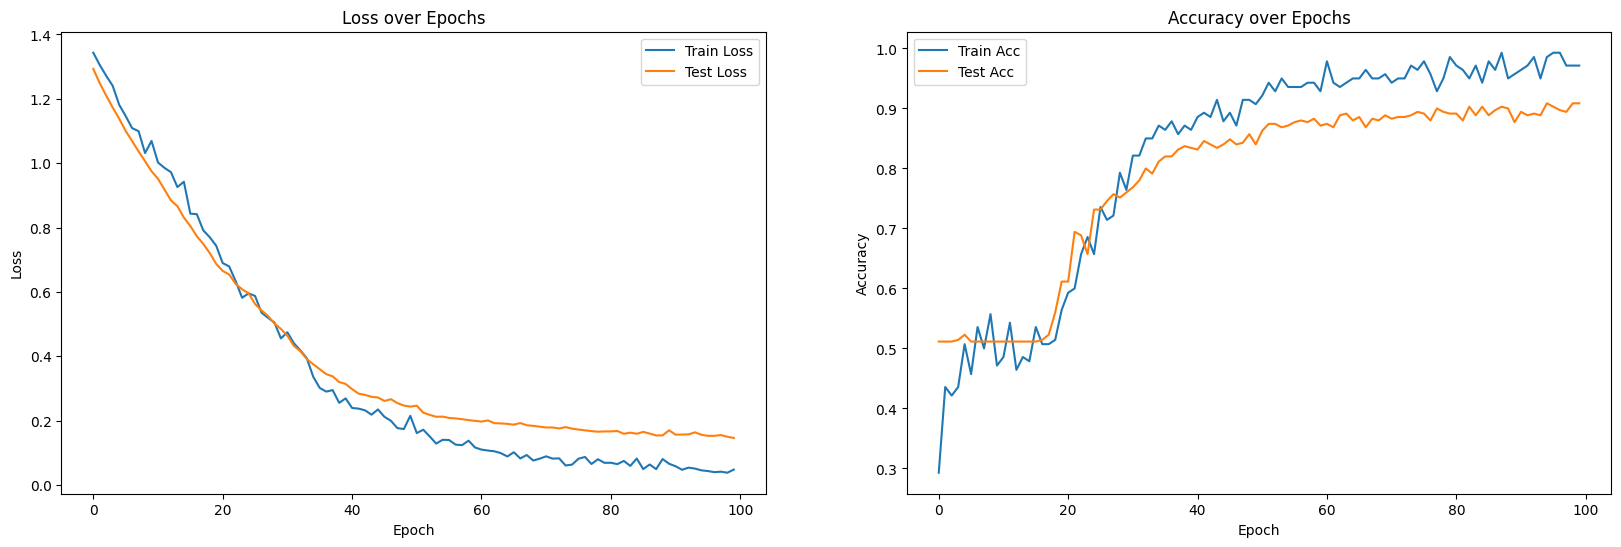

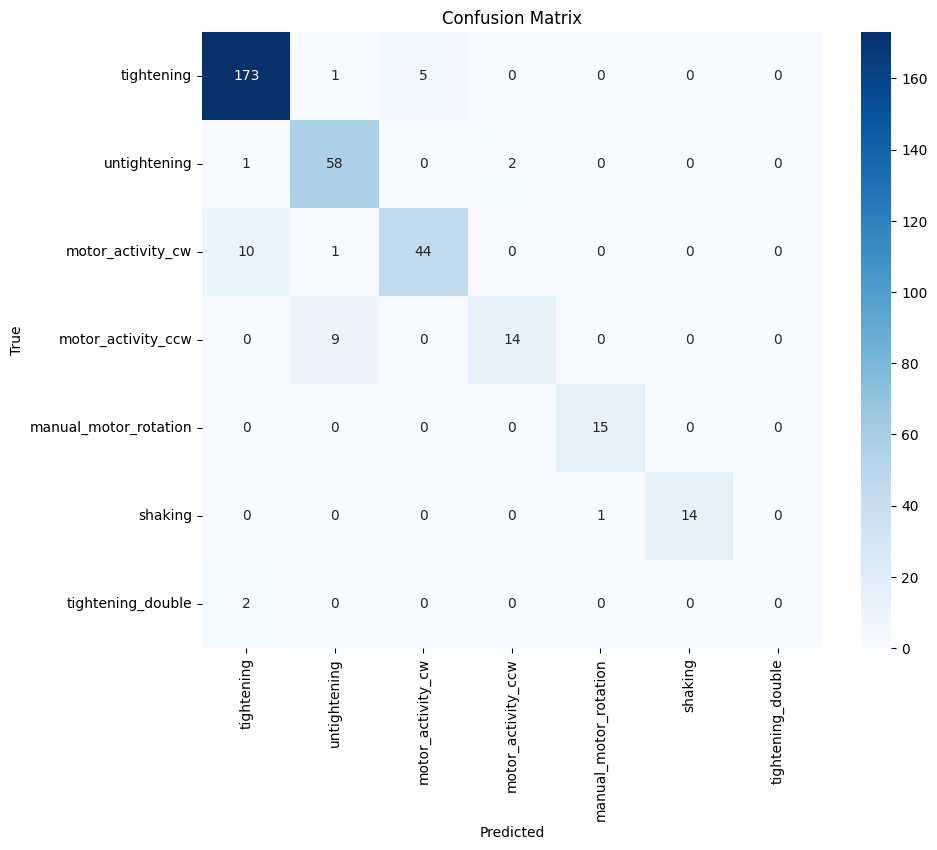


Selected Labeled Indices in round 1 (20 samples)
Selected indices: tensor([   4, 1209,  301,  470, 1217,  420, 1155,  590,   33,  781,  135,  446,
         167, 1169,  855, 1190,  731,  975,  360, 1140])
Updated labeled pool: 160 samples
Remaining unlabeled pool: 1240 samples
Training samples count for weights initialization: tensor([64, 27, 25, 11,  5,  7,  1])
Updated Labeled Pool label distribution:
  Label 2: 65 samples
  Label 3: 28 samples
  Label 4: 34 samples
  Label 5: 11 samples
  Label 6: 5 samples
  Label 7: 13 samples
  Label 14: 4 samples

--- Active Learning Round 2 ---
Epoch [1/100]
  Train Loss: 1.5439, Test Loss: 1.4569
  Train Acc: 0.0312, Test Acc: 0.0429
Epoch [2/100]
  Train Loss: 1.4280, Test Loss: 1.3401
  Train Acc: 0.0813, Test Acc: 0.0743
Epoch [3/100]
  Train Loss: 1.3615, Test Loss: 1.2692
  Train Acc: 0.1437, Test Acc: 0.1657
Epoch [4/100]
  Train Loss: 1.2929, Test Loss: 1.2123
  Train Acc: 0.2875, Test Acc: 0.2057
Epoch [5/100]
  Train Loss: 1.2343, Tes

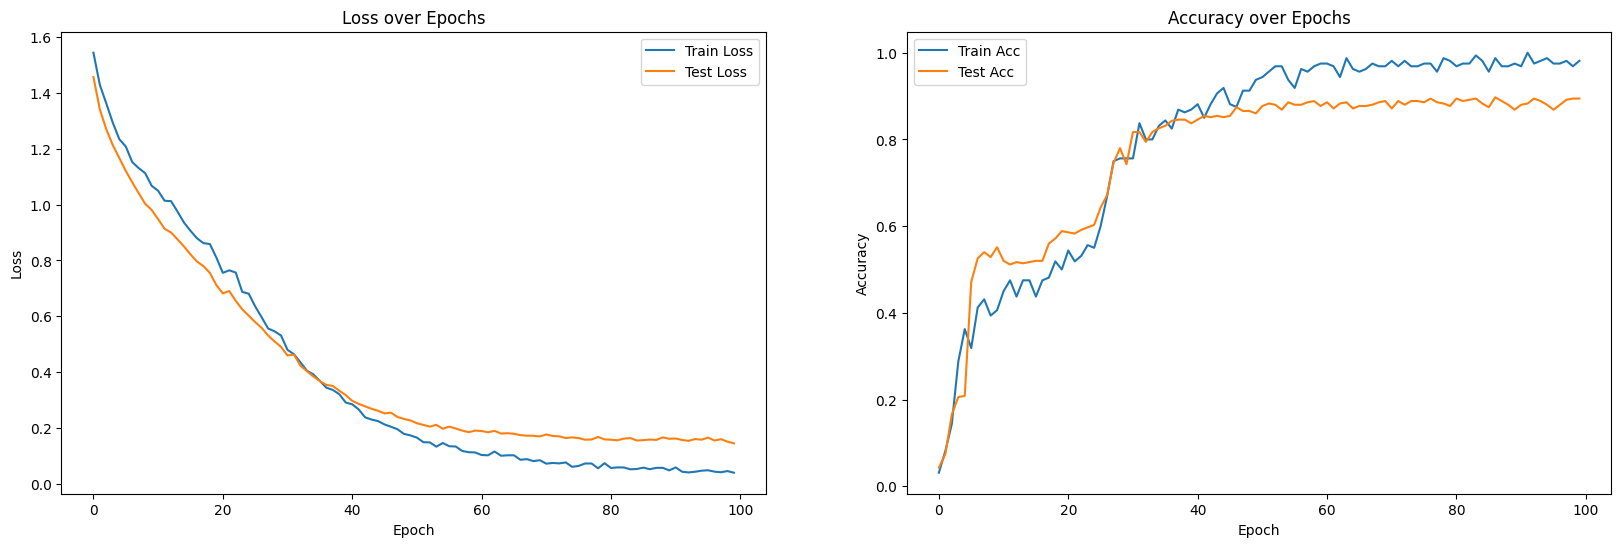

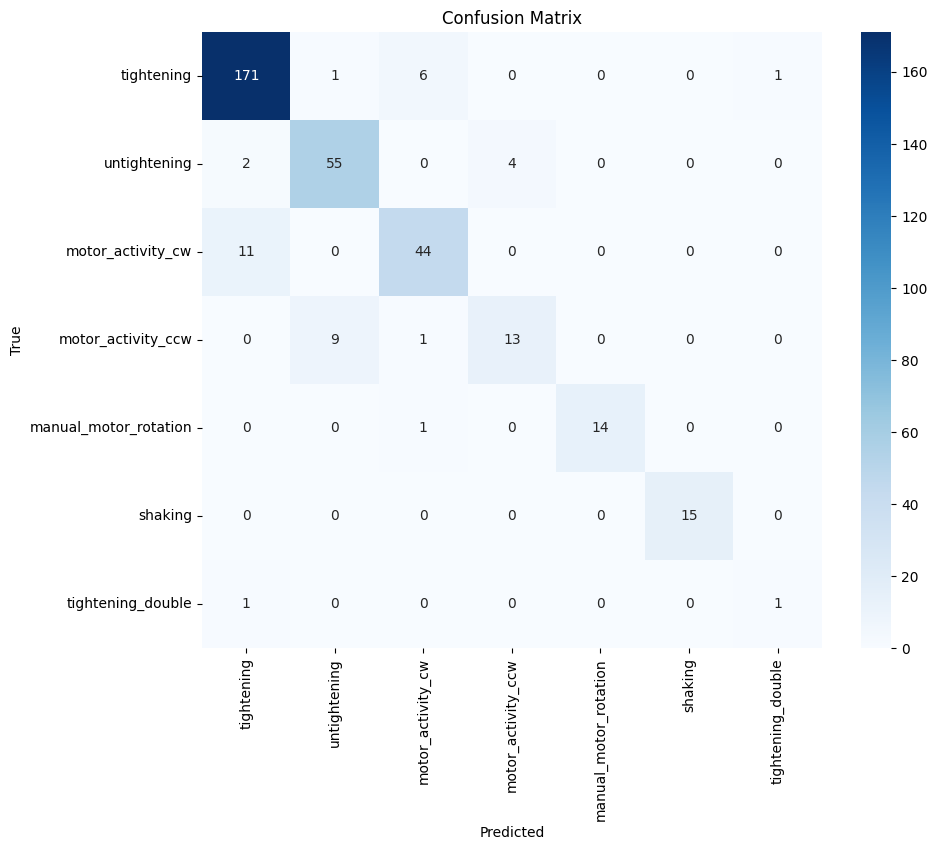


Selected Labeled Indices in round 2 (20 samples)
Selected indices: tensor([ 906,  745,  201,  715,  733,  275,  774,  148, 1107, 1197, 1237,  797,
        1143,  128, 1054, 1214,  876,   24,  898,  367])
Updated labeled pool: 180 samples
Remaining unlabeled pool: 1220 samples
Training samples count for weights initialization: tensor([65, 28, 34, 11,  5, 13,  4])
Updated Labeled Pool label distribution:
  Label 2: 67 samples
  Label 3: 32 samples
  Label 4: 37 samples
  Label 5: 15 samples
  Label 6: 8 samples
  Label 7: 16 samples
  Label 14: 5 samples

--- Active Learning Round 3 ---
Epoch [1/100]
  Train Loss: 1.5039, Test Loss: 1.4666
  Train Acc: 0.0944, Test Acc: 0.0457
Epoch [2/100]
  Train Loss: 1.4261, Test Loss: 1.3922
  Train Acc: 0.1000, Test Acc: 0.0457
Epoch [3/100]
  Train Loss: 1.3777, Test Loss: 1.3173
  Train Acc: 0.1833, Test Acc: 0.3343
Epoch [4/100]
  Train Loss: 1.3295, Test Loss: 1.2549
  Train Acc: 0.2389, Test Acc: 0.5114
Epoch [5/100]
  Train Loss: 1.3125, Tes

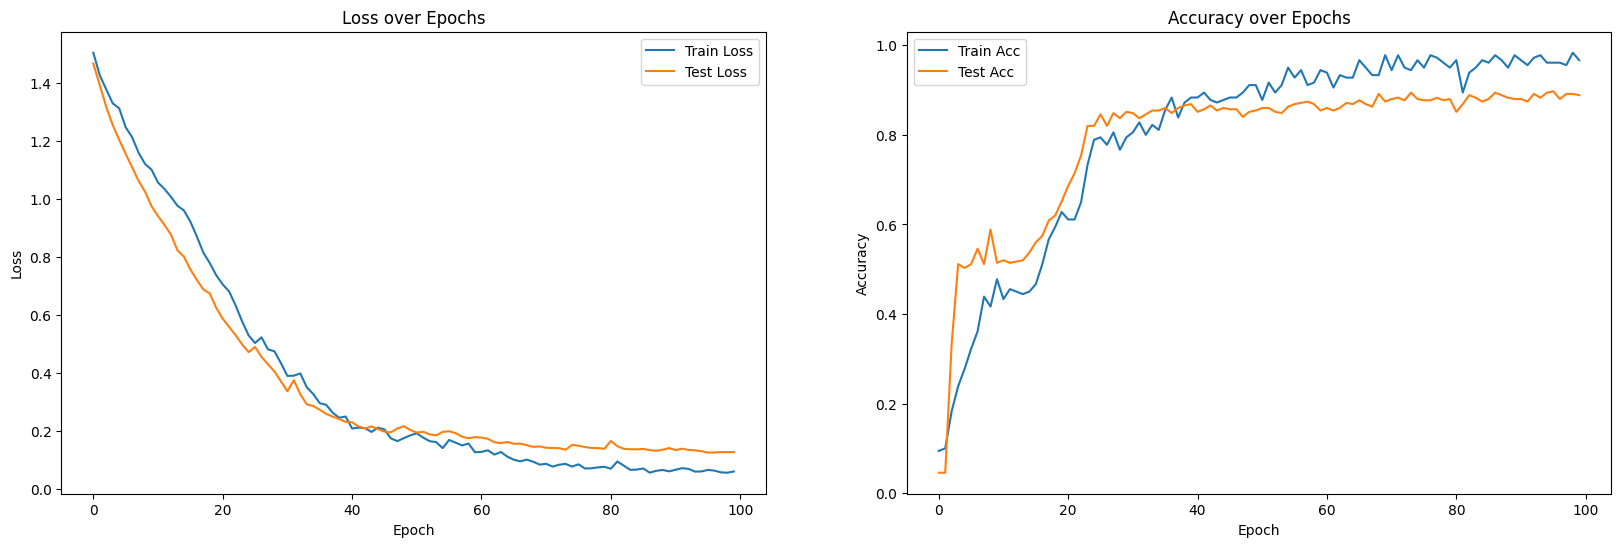

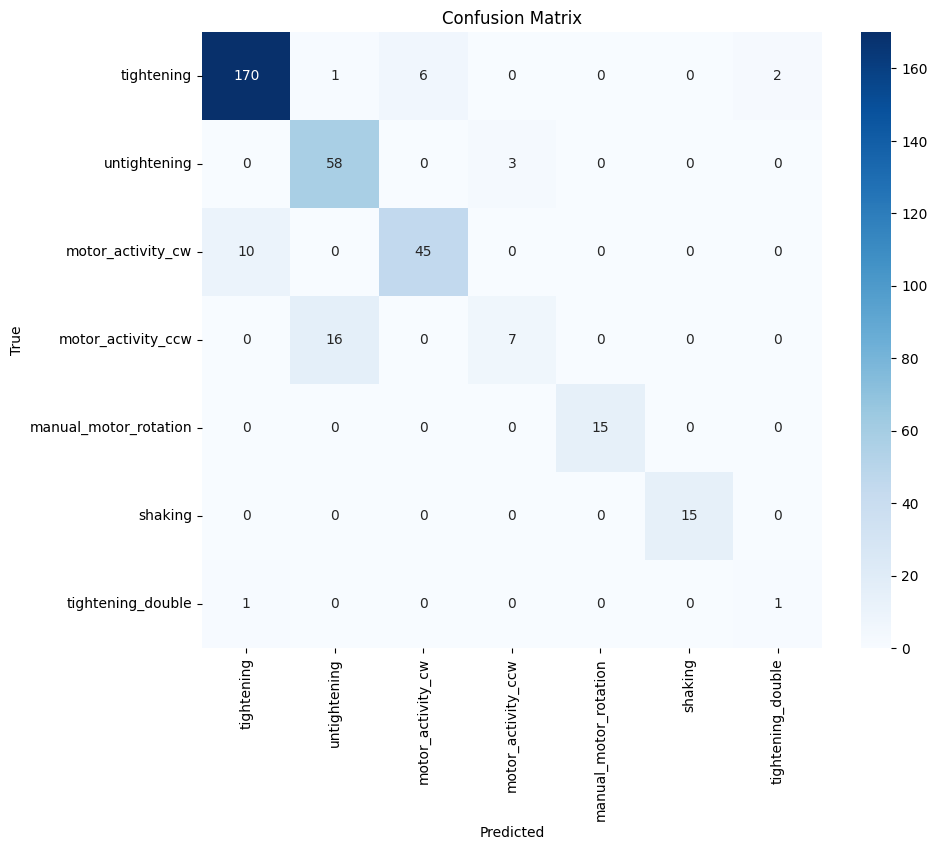


Selected Labeled Indices in round 3 (20 samples)
Selected indices: tensor([1097, 1209,  935,   39,  734,  529,  201, 1202,  718,  633,  105,  413,
         900, 1188,  894,   43,  332,  905, 1161,  576])
Updated labeled pool: 200 samples
Remaining unlabeled pool: 1200 samples
Training samples count for weights initialization: tensor([67, 32, 37, 15,  8, 16,  5])
Updated Labeled Pool label distribution:
  Label 2: 69 samples
  Label 3: 36 samples
  Label 4: 37 samples
  Label 5: 27 samples
  Label 6: 9 samples
  Label 7: 16 samples
  Label 14: 6 samples

--- Active Learning Round 4 ---
Epoch [1/100]
  Train Loss: 1.3768, Test Loss: 1.2455
  Train Acc: 0.2350, Test Acc: 0.5114
Epoch [2/100]
  Train Loss: 1.2896, Test Loss: 1.1568
  Train Acc: 0.3150, Test Acc: 0.5114
Epoch [3/100]
  Train Loss: 1.2404, Test Loss: 1.1019
  Train Acc: 0.3450, Test Acc: 0.5114
Epoch [4/100]
  Train Loss: 1.2119, Test Loss: 1.0504
  Train Acc: 0.3550, Test Acc: 0.5114
Epoch [5/100]
  Train Loss: 1.1510, Tes

c:\Users\vinee\anaconda3\envs\tool-tracking_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vinee\anaconda3\envs\tool-tracking_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vinee\anaconda3\envs\tool-tracking_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

                       precision    recall  f1-score   support

           tightening       0.93      0.96      0.95       179
         untightening       0.87      0.95      0.91        61
    motor_activity_cw       0.83      0.80      0.81        55
   motor_activity_ccw       0.87      0.57      0.68        23
manual_motor_rotation       0.94      1.00      0.97        15
              shaking       1.00      0.93      0.97        15
    tightening_double       0.00      0.00      0.00         2

             accuracy                           0.90       350
            macro avg       0.78      0.74      0.75       350
         weighted avg       0.90      0.90      0.90       350



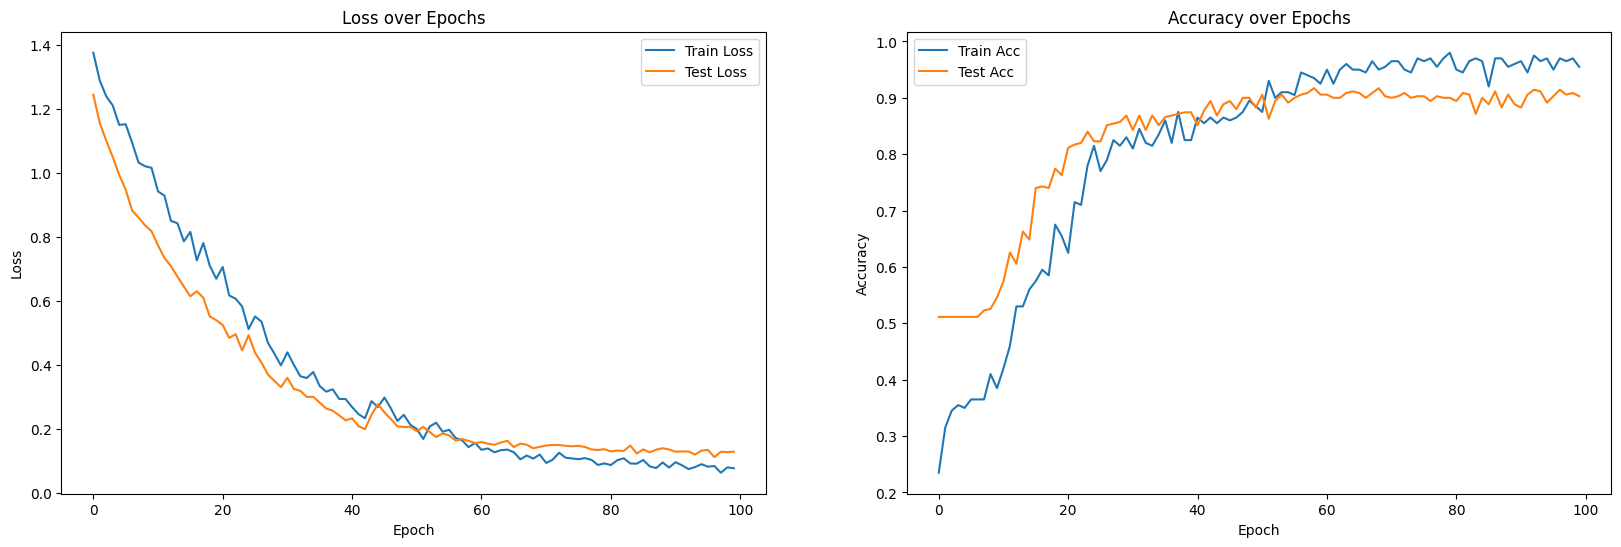

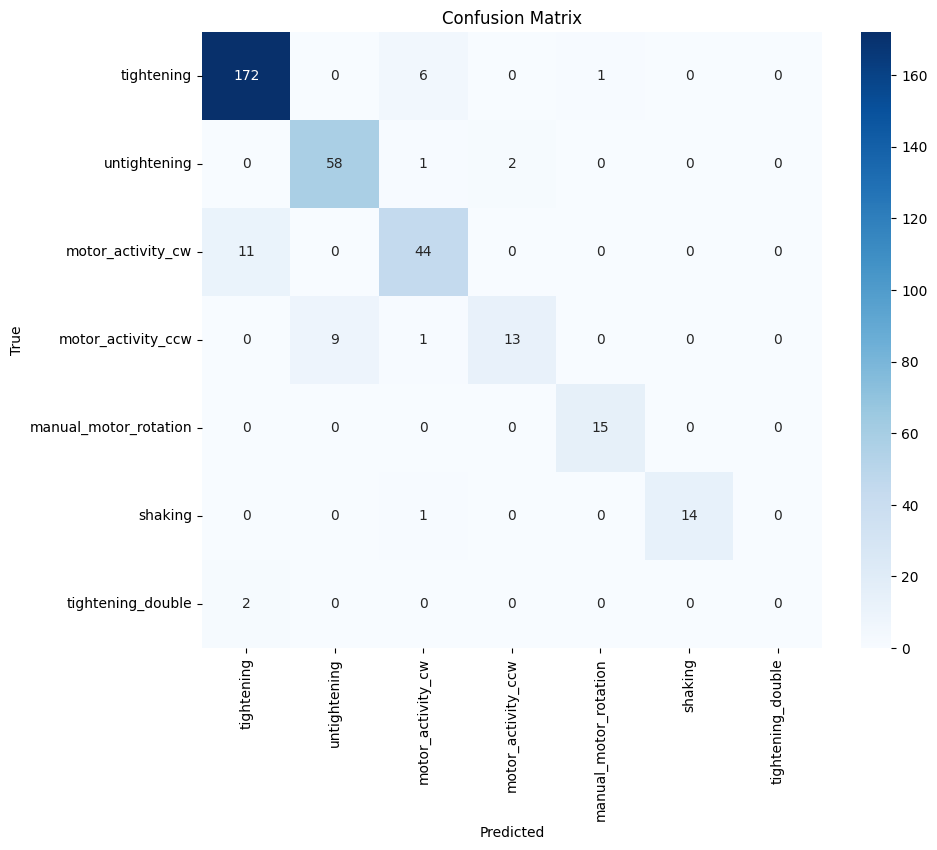


Selected Labeled Indices in round 4 (20 samples)
Selected indices: tensor([ 815, 1175,  413, 1120,  212,  758,   89,  597,  361,  194,  119,  965,
         781,  974,  877, 1090,  207,  602,  303, 1072])
Updated labeled pool: 220 samples
Remaining unlabeled pool: 1180 samples
Training samples count for weights initialization: tensor([69, 36, 37, 27,  9, 16,  6])
Updated Labeled Pool label distribution:
  Label 2: 73 samples
  Label 3: 39 samples
  Label 4: 39 samples
  Label 5: 30 samples
  Label 6: 9 samples
  Label 7: 21 samples
  Label 14: 9 samples

--- Active Learning Round 5 ---
Epoch [1/100]
  Train Loss: 1.4406, Test Loss: 1.3590
  Train Acc: 0.1682, Test Acc: 0.2200
Epoch [2/100]
  Train Loss: 1.3920, Test Loss: 1.2859
  Train Acc: 0.2136, Test Acc: 0.3743
Epoch [3/100]
  Train Loss: 1.3391, Test Loss: 1.2125
  Train Acc: 0.2818, Test Acc: 0.5229
Epoch [4/100]
  Train Loss: 1.2930, Test Loss: 1.1574
  Train Acc: 0.3182, Test Acc: 0.5114
Epoch [5/100]
  Train Loss: 1.2754, Tes

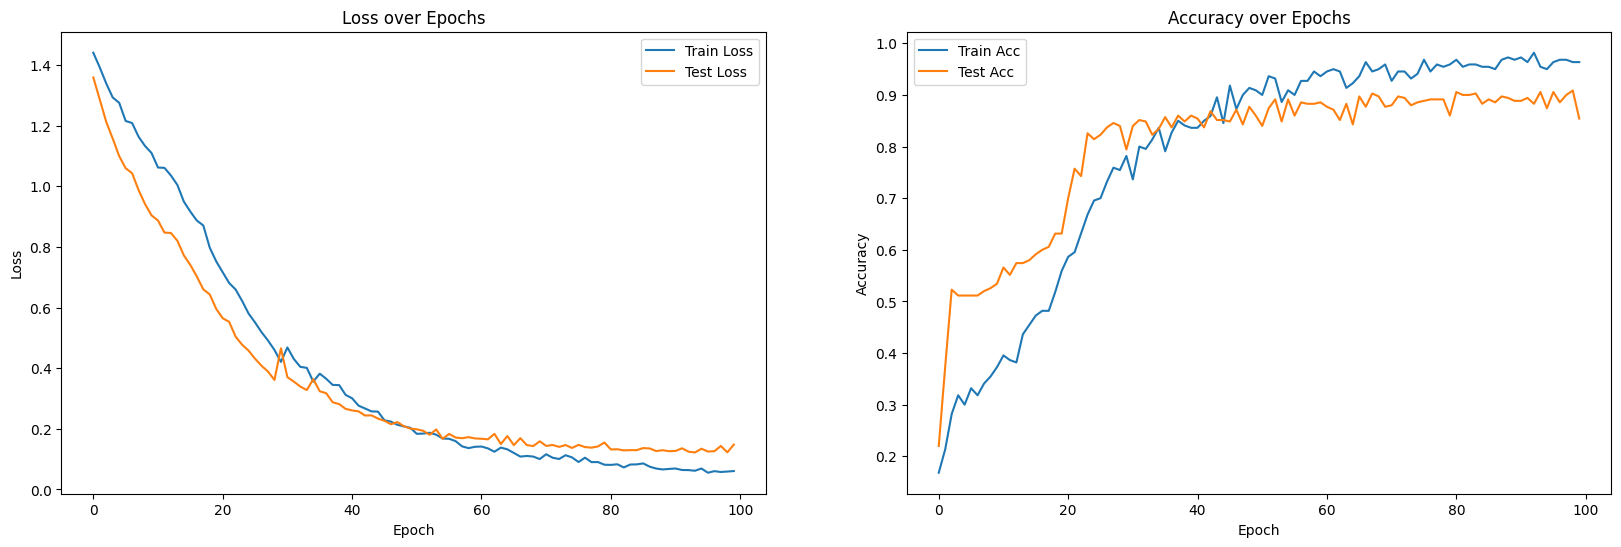

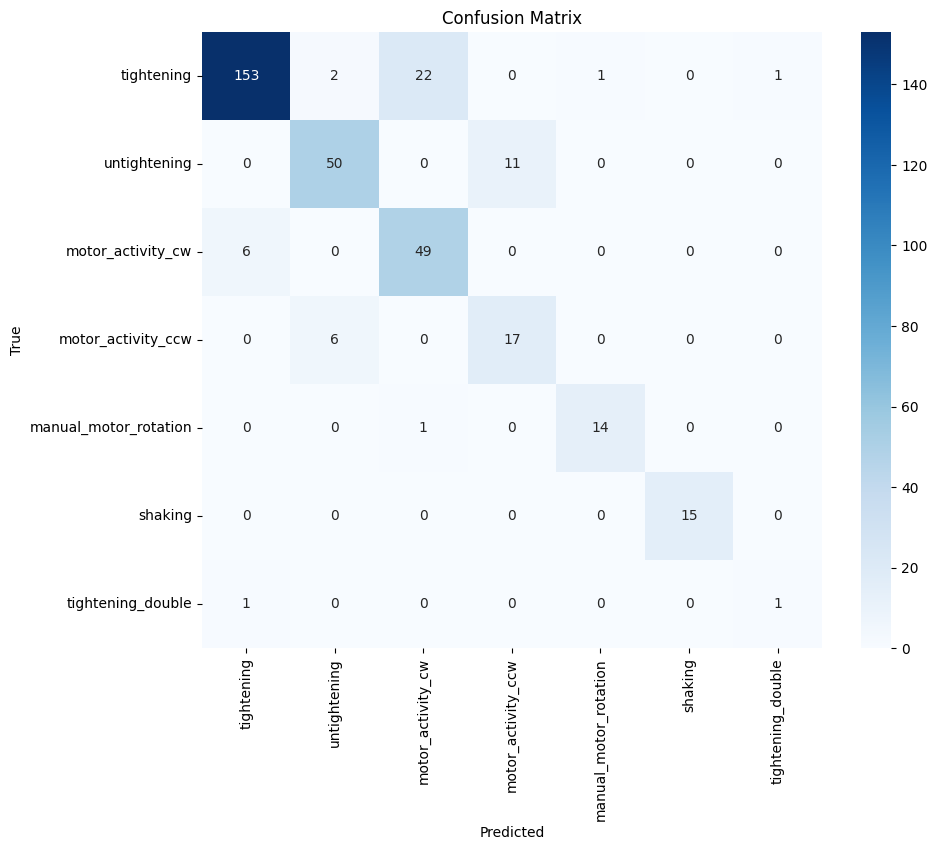


Selected Labeled Indices in round 5 (20 samples)
Selected indices: tensor([ 624,   19,  828,  284,  247,  991,   39,   88,  990, 1093, 1136,  179,
         185,  711,  164,  855,  611,  529, 1164,  213])
Updated labeled pool: 240 samples
Remaining unlabeled pool: 1160 samples
Training samples count for weights initialization: tensor([73, 39, 39, 30,  9, 21,  9])
Updated Labeled Pool label distribution:
  Label 2: 86 samples
  Label 3: 40 samples
  Label 4: 45 samples
  Label 5: 30 samples
  Label 6: 9 samples
  Label 7: 21 samples
  Label 14: 9 samples

--- Active Learning Round 6 ---
Epoch [1/100]
  Train Loss: 1.3666, Test Loss: 1.2544
  Train Acc: 0.1875, Test Acc: 0.5114
Epoch [2/100]
  Train Loss: 1.3057, Test Loss: 1.1604
  Train Acc: 0.3250, Test Acc: 0.5114
Epoch [3/100]
  Train Loss: 1.2506, Test Loss: 1.0921
  Train Acc: 0.3542, Test Acc: 0.5114
Epoch [4/100]
  Train Loss: 1.2067, Test Loss: 1.0415
  Train Acc: 0.3625, Test Acc: 0.5114
Epoch [5/100]
  Train Loss: 1.1862, Tes

c:\Users\vinee\anaconda3\envs\tool-tracking_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vinee\anaconda3\envs\tool-tracking_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vinee\anaconda3\envs\tool-tracking_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

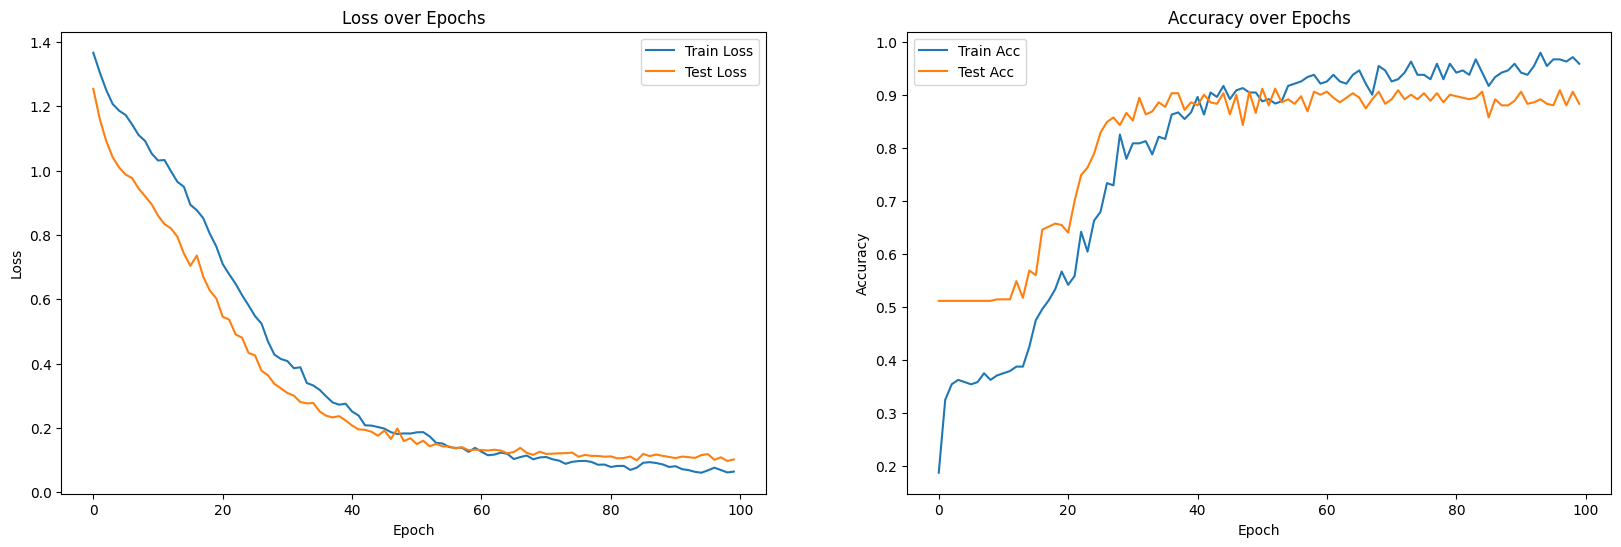

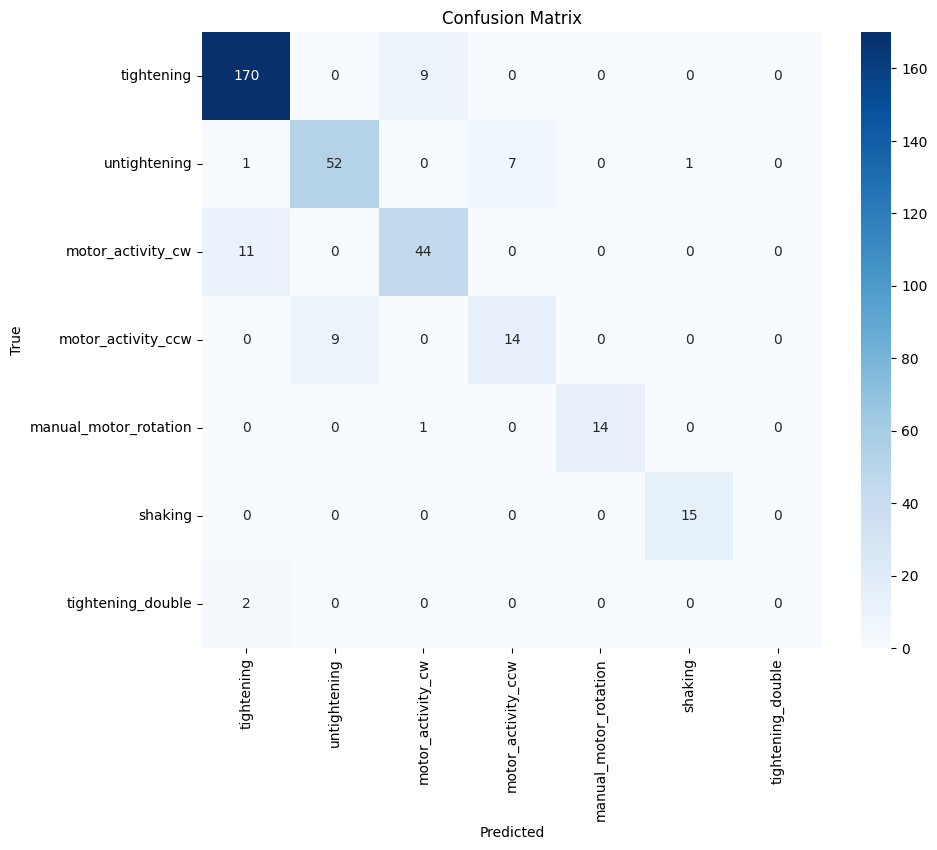


Selected Labeled Indices in round 6 (20 samples)
Selected indices: tensor([ 440,  282,  989,   91, 1016,  819,   38,  215, 1034, 1062,  561, 1048,
         109,  131,  379,  660,  123,  278,  178,  464])
Updated labeled pool: 260 samples
Remaining unlabeled pool: 1140 samples
Training samples count for weights initialization: tensor([86, 40, 45, 30,  9, 21,  9])
Updated Labeled Pool label distribution:
  Label 2: 89 samples
  Label 3: 49 samples
  Label 4: 51 samples
  Label 5: 31 samples
  Label 6: 9 samples
  Label 7: 21 samples
  Label 14: 10 samples


In [19]:
#--------------------------------- [START] Main Active Learning Loop -----------------------------------------------------------

# Active Learning Parameters
num_queries = 5 if mytool == "pneumatic_screwdriver" else 5           # How many active learning rounds
samples_per_query = 100 if mytool == "pneumatic_screwdriver" else 20      # How many samples to add per round
uncertainity_strategy = 'lc'  # 'lc', 'sm', or 'entropy'
uncertainity_strategy_batch_size = 32  # Batch size for uncertainty sampling

strategy_map = {
    'lc': 'Least Confidence',
    'sm': 'Small Margin',
    'entropy': 'Entropy'
}

import pandas as pd

results_summary = pd.DataFrame(columns=[
    "Round", "AL_Method", "Training_Batch_Size","Uncertainity_Strategy_Batch_Size", "x", "Num_Samples","Selected_Indices", "Train_Acc", "Test_Acc", "Train_Loss", "Test_Loss"
])


for num in range(num_queries + 1):
    print(f"\n--- Active Learning Round {num + 1} ---")


    # Train model and collect metrics
    model, train_acc, test_acc, train_loss, test_loss = train_test_lstm()


    # Build row as a dict
    row_dict = {
        "Round": num,
        "AL_Method": strategy_map.get(uncertainity_strategy, 'Unknown'),
        "Training_Batch_Size": batch_size,
        "Uncertainity_Strategy_Batch_Size": uncertainity_strategy_batch_size,
        "Samples_per_query": 0 if num == 0 else samples_per_query,
        "Num_Samples": len(y_labeled),
        "Selected_Indices": str(initial_indices_global.tolist()) if num == 0 else str(selected_indices.tolist()),
        "Train_Acc": round(train_acc * 100, 2),
        "Test_Acc": round(test_acc * 100, 2),
        "Train_Loss": round(train_loss, 4),
        "Test_Loss": round(test_loss, 4)
    }


    # Append row using loc
    results_summary.loc[len(results_summary)] = row_dict

        # Select most uncertain samples from unlabeled pool
    selected_indices, selected_probs = uncertainty_sampling(
    model, X_unlabeled_pool, strategy= uncertainity_strategy, k=samples_per_query, us_batch_size=uncertainity_strategy_batch_size
)

    # Display selected indices
    display_selected_indices(selected_indices, title=f"Selected Labeled Indices in round {num + 1}")

    # Update pools and train_loader
    train_loader = update_pools(selected_indices)

    print("Training samples count for weights initialization:", counts_train)
    
    # Optional: Check new label distribution
    unique_train, counts_train = print_label_distribution(y_labeled, label_encoder, name='Updated Labeled Pool')


In [20]:
print("\n--- Summary of Active Learning Rounds ---")
print(results_summary)

# Save to CSV
csv_path = f"active_learning_results_{mytool}.csv"
if not os.path.exists(csv_path):
    results_summary.to_csv(csv_path, index=False)
else:
    results_summary.to_csv(csv_path, mode='a', header=False, index=False)
print(f"\nResults saved to {csv_path}")



--- Summary of Active Learning Rounds ---
   Round         AL_Method  Training_Batch_Size  \
0      0  Least Confidence                   32   
1      1  Least Confidence                   32   
2      2  Least Confidence                   32   
3      3  Least Confidence                   32   
4      4  Least Confidence                   32   
5      5  Least Confidence                   32   

   Uncertainity_Strategy_Batch_Size   x  Num_Samples  \
0                                32 NaN          140   
1                                32 NaN          160   
2                                32 NaN          180   
3                                32 NaN          200   
4                                32 NaN          220   
5                                32 NaN          240   

                                    Selected_Indices  Train_Acc  Test_Acc  \
0  [210, 1381, 468, 1114, 375, 702, 868, 306, 117...      97.14     90.86   
1  [4, 1209, 301, 470, 1217, 420, 1155, 590, 33, ...